# 07. 온라인과 일괄 학습

## 07-1. 개요

7장에서는 데이터셋이 너무 커서 작업 중인 컴퓨터 메모리에 적시에 적합할 수 없는 문제가 있더라도 잘 작동할 수 있게 하는 방법에 대해 알아봅니다. (빅데이터에 대한 클래시파이어 훈련과 관련해 모범 사례를 소개합니다.)

7장의 진행 순서는 배치 학습 & 한계점 -> 온라인 학습 -> 빅데이터 예제 순 입니다.

지금까지 배웠던 고전적인 접근 방법인 일괄 학습이 아닌 새로운 접근법을 배워봅시다.

- **온라인 학습** 

온라인 학습의 핵심은 **분할 및 정복의 원리**입니다. 
미니 배치의 각 단계는 클래시파이어를 훈련시키고 향상시키기 위한 입력 역할을 합니다.

온라인 학습은 확장성 및 일반성 모두를 제공하므로 관찰 횟수가 많은 데이터셋에 적합합니다. 게다가 이 접근 방식을 사용하면 동시에 모두 사용 가능한 것은 아니지만 즉시 전송되는 관찰치가 있는 데이터셋인 스트리밍 데이터셋을 처리할 수 있습니다. 또한 이러한 접근 방식은 훈련 과정에서 더 많은 데이터가 입력되기 때문에 정밀도가 향상된다는 장점이 있습니다.

## 07-2. 배치 학습

지도 작업의 시작 부분에서 데이터셋을 완전히 사용할 수 있고 컴퓨터의 RAM 용량을 초과하지 않으면, 배치 학습을 사용해 클래시파이어 또는 회귀를 훈련할 수 있다. 훈련 중에는 전체 데이터셋을 스캔합니다.(확률적 기울기 하강을 기반으로 한 방법이 사용되는 경우에도 동일함.)

이제 선형 리그레서를 훈련시키고 성능을 데이터셋의 관찰 횟수(즉, 특성 행렬 X의 행의 개수)와 특성의 수(즉, X의 열의 개수)에 연결하는 데 필요한 시간을 비교해봅시다.

첫 번째 실험에서는 Scikit-learn이 제공하는 단순한 클래스 LinearRegression()과 SGDRegressor()를 사용하고, 병렬 처리 없이 클래시파이어를 적합시키는 데 걸리는 시간을 저장할 것입니다.

먼저 모조 데이터셋을 생성하는 함수(generate_dataset) 를 만들어봅시다.
이 함수는 훈련 포인트의 수와 특성의 수(선택적으로 노이즈 분산 추가)를 파라미터로 사용하고, 정규화된 훈련 및 테스트 특성 행렬 그리고 라벨을 반환합니다. (X행렬에 있는 모든 특성은 숫자임)

In [69]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_regression
import numpy as np

def generate_dataset(n_train, n_test, n_features, noise=0.1):
    X, y = make_regression(n_samples = int(n_train + n_test),
                          n_features = int(n_features),
                          noise = noise,
                          random_state = 101)
    
    X_train = X[:n_train]
    X_test = X[n_train:]

    y_train = y[:n_train]
    y_test = y[n_train:]

    X_scaler = StandardScaler() #평균 0, 표준편차 1이 되도록 함. (표준화)
    X_train = X_scaler.fit_transform(X_train) #fit(훈련데이터에서 모델 파라미터를 학습) 과 transform(학습한 파라미터로 데이터를 변환) 실행함
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1,1)) #.reshape(-1,1) 로 수정
    y_test = y_scaler.transform(y_test.reshape(-1,1)) #.reshape(-1,1) 로 수정
    
    return X_train, X_test, y_train, y_test

이제 다음 구성의 모든 조합으로 학습자를 훈련시키고 테스트하는 데 필요한 시간을 저장해봅시다.
- 두 개의 클래시파이어 : LinearRegression()과 SGDRegressor()
- 관찰 수 : 1,000, 10,000 과 100,000
- 특성 수 : 10, 50, 100, 500 과 1,000

각각의 훈련 작업은 5번 수행되고, 테스트 데이터셋은 항상 100개의 관찰치로 구성되며, 평균을 구해 결과로 사용합니다. 조금 오래 걸립니다.. (9분정도)

In [70]:
from sklearn.linear_model import LinearRegression, SGDRegressor
import time

n_test = 1000

n_train_v = (1000,10000,100000)
n_features_v = (10,50,100,500,1000)
regr_v = {'LR': LinearRegression(), 'SGD' : SGDRegressor(max_iter = 1000, tol = 1e-3, random_state = 101)} #max_iter, tol 추가
results = {}

for regr_name, regr in regr_v.items():
    results[regr_name] = {}
    for n_train in n_train_v:
        for n_features in n_features_v:
            results[regr_name][(n_train, n_features)] = {'train' : [], 'pred' : []}
            for n_repetition in range(5): #훈련 작업은 각각 5번 수행
                X_train, X_test, y_train, y_test = generate_dataset(n_train, n_test, n_features)
            
                tick = time.time() #시작 시간
                regr.fit(X_train, np.ravel(y_train)) #np.ravel() 수정
                train_time = time.time() - tick # train_time = 끝난 시각 - 시작 시각
            
                pred = regr.predict(X_test)
                predict_time = time.time() - tick - train_time #predict_time = 예측 끝난 시각 - 훈련 끝난 시각
            
                results[regr_name][(n_train, n_features)]['train'].append(train_time)
                results[regr_name][(n_train, n_features)]['pred'].append(predict_time)     

최종적으로 결과를 플롯해보자. 다음 스크린샷에서 왼쪽 차트는 특성 수에 대한 LogisticRegressor 알고리즘의 훈련시간을 보여주는 반면, 오른쪽 차트는 관찰 수에 대한 시간을 나타낸다.

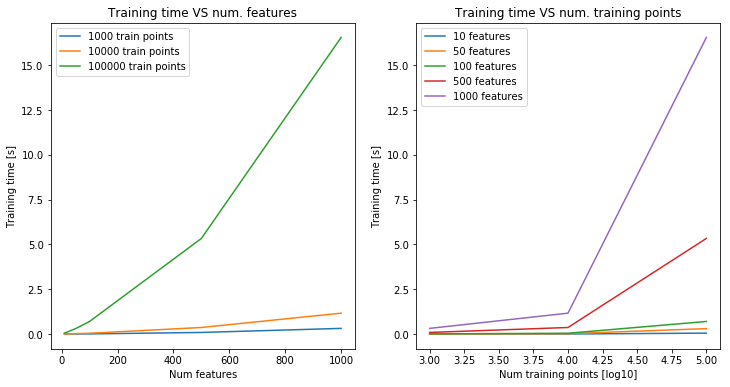

In [72]:
pylab.rcParams['figure.figsize'] = 12,6
plt.subplot(1,2,1)

for n_train in n_train_v:
    X = n_features_v
    y = [np.mean(results['LR'][(n_train, n_features)]['train']) for n_features in n_features_v]
    plt.plot(X, y, label = str(n_train) + " train points")
    
plt.title('Training time VS num. features')
plt.xlabel('Num features')
plt.ylabel('Training time [s]')
plt.legend(loc = 0)

plt.subplot(1,2,2)

for n_features in n_features_v:
    X = np.log10(n_train_v)
    y = [np.mean(results['LR'][(n_train, n_features)]['train']) for n_train in n_train_v]
    plt.plot(X, y, label=str(n_features) + " features")
    
plt.title('Training time VS num. training points')
plt.xlabel('Num training points [log10]')
plt.ylabel('Training time [s]')
plt.legend(loc = 0)

plt.show()

플롯에서 볼 수 있듯이, 작은 수의 특성과 관찰치를 가진 작은 데이터셋에서 클래시파이어는 상당히 우수하다는 것을 알 수 있습니다. 가장 큰 X 행렬, 1000개의 특성 그리고 100,000개의 관찰치(1억 개의 요소를 포함)를 처리하는 동안 훈련 시간은 20초를 약간 넘습니다. 이것은 리그레서가 더 이상 스케일이 커지지 않는 한계이기도 합니다.

이제 테스트 시간에 어떤 일이 발생하는지 살펴봅시다.

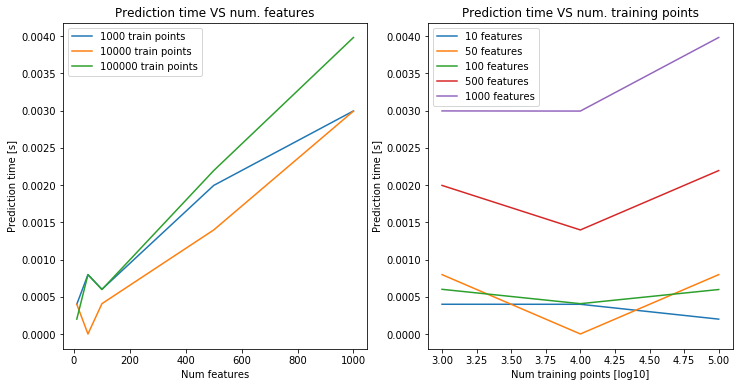

In [73]:
plt.subplot(1,2,1)

for n_train in n_train_v:
    X = n_features_v
    y = [np.mean(results['LR'][(n_train, n_features)]['pred']) for n_features in n_features_v]
    
    plt.plot(X,y,label=str(n_train) + " train points")
    
plt.title('Prediction time VS num. features')
plt.xlabel('Num features')
plt.ylabel('Prediction time [s]')
plt.legend(loc=0)

plt.subplot(1,2,2)
    
for n_features in n_features_v:
    X = np.log10(n_train_v)
    y = [np.mean(results['LR'][(n_train, n_features)]['pred']) for n_train in n_train_v]
        
    plt.plot(X,y,label=str(n_features) + " features")
        
plt.title('Prediction time VS num. training points')
plt.xlabel('Num training points [log10]')
plt.ylabel('Prediction time [s]')
plt.legend(loc=0)
    
plt.show()

테스트 시간은 특성 수의 선형 함수로 조정됩니다. 다행히도 선형 접근 방식을 적용하는 것이 빅데이터에 큰 문제가 되지는 않는 것 같아 보입니다.

다음은 선형회귀의 SGD 구현 시 어떤 일이 발생하는지 살펴봅시다.

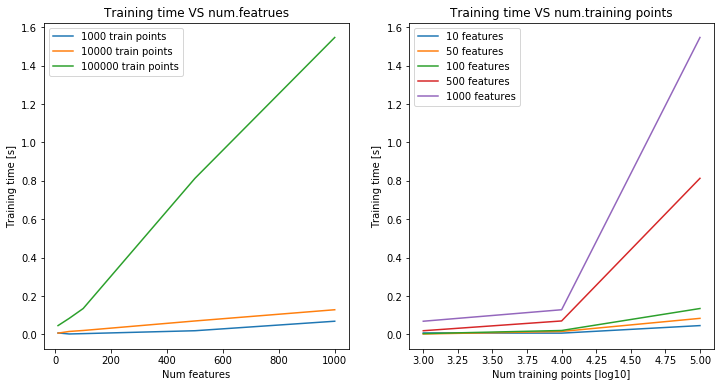

In [74]:
plt.subplot(1,2,1)

for n_train in n_train_v:
    X = n_features_v
    y = [np.mean(results['SGD'][(n_train, n_features)]['train']) for n_features in n_features_v]
    
    plt.plot(X,y,label=str(n_train) + " train points")
    
plt.title('Training time VS num.featrues')
plt.xlabel('Num features')
plt.ylabel('Training time [s]')
plt.legend(loc=0)

plt.subplot(1,2,2)
    
for n_features in n_features_v:
    X = np.log10(n_train_v)
    y = [np.mean(results['SGD'][(n_train, n_features)]['train']) for n_train in n_train_v]
        
    plt.plot(X,y,label=str(n_features) + " features")
        
plt.title('Training time VS num.training points')
plt.xlabel('Num training points [log10]')
plt.ylabel('Training time [s]')
plt.legend(loc=0)
    
plt.show()

이전의 리그레서와 비교해 결과가 크게 변화되었습니다. 가장 큰 행렬에서 2초 조금 넘게 걸립니다. 또한 SGD 리그레서를 훈련시키는 데 필요한 시간은 특성의 수과 훈련 포인트의 수에 대해 선형적인 것으로 보입니다. 

이제 테스트에서 어떻게 작동하는지 확인해봅시다.

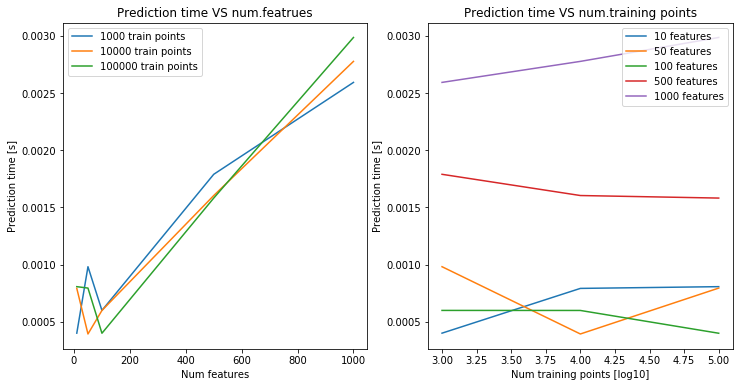

In [75]:
plt.subplot(1,2,1)

for n_train in n_train_v:
    X = n_features_v
    y = [np.mean(results['SGD'][(n_train, n_features)]['pred']) for n_features in n_features_v]
    
    plt.plot(X,y,label=str(n_train) + " train points")
    
plt.title('Prediction time VS num.featrues')
plt.xlabel('Num features')
plt.ylabel('Prediction time [s]')
plt.legend(loc=0)

plt.subplot(1,2,2)
    
for n_features in n_features_v:
    X = np.log10(n_train_v)
    y = [np.mean(results['SGD'][(n_train, n_features)]['pred']) for n_train in n_train_v]
        
    plt.plot(X,y,label=str(n_features) + " features")
        
plt.title('Prediction time VS num.training points')
plt.xlabel('Num training points [log10]')
plt.ylabel('Prediction time [s]')
plt.legend(loc=0)
    
plt.show()

SGD 기반 학습자를 테스트 데이터셋에 적용하면 다른 구현과 거의 동일한 시간이 소요됩니다. 여기서도 빅데이터셋에서 솔루션을 확장할 때 문제가 발생하지 않는 것을 볼 수 있습니다.

## 07-3 온라인 미니 배치 학습

이전 절에서 빅데이터의 경우 SGD 기반 학습이 더 빠르고 확장성이 있기 때문에 항상 SGD 기반 학습자를 사용한다는 교훈을 얻었습니다.
이 절에서 다음과 같은 회귀 데이터셋을 고려해봅시다.
- 대규모 관찰치 : 2M
- 다양한 특성 수 : 100
- 노이즈 데이터셋

X_train 행렬은 2억 개의 요소로 구성되며, 메모리에 완전히 들어가지 않을 수 있습니다.
(Ex. RAM이 4GB인 시스템의 경우 테스트셋은 10,000개의 관찰치로 구성된다.

먼저 데이터셋을 생성하고 가장 큰 데이터셋의 메모리 사용량을 출력해봅시다.

In [77]:
#Let's generate a 1M dataset
X_train, X_test, y_train, y_test =  generate_dataset(2000000, 10000,100,10.0)
print("Size of X_train is [GB]:", X_train.size * X_train[0,0].itemsize/1E9)

Size of X_train is [GB]: 1.6


X_train 행렬 자체는 1.6GB의 데이터이므로, 빅데이터로 간주할 수 있습니다. 이전 절에서 SGDRegressor()으로 얻은 최상의 모델을 사용해 분류해봅시다. 성능을 측정하기위해 평균절대오차(MAE : Mean Absolute Error)를 사용합니다. (오차 평가의 경우 낮을수록 더 좋다)

In [90]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, SGDRegressor
import time
import numpy as np

regr = SGDRegressor(max_iter = 1000, tol = 1e-3, random_state=101) #수정
tick = time.time()

regr.fit(X_train, np.ravel(y_train)) #수정
print("With SGD, after", time.time() - tick, "seconds")
pred = regr.predict(X_test)
print("the MAE is [log10]:", np.log10(mean_absolute_error(y_test,pred)))

With SGD, after 2.6688625812530518 seconds
the MAE is [log10]: -1.2412866847845854


windows10 OS와 8GB RAM 컴퓨터에서 이 작업은 약 3초 정도 걸리며, 최종 MAE는 10의 -1.2제곱이다.

미니 배치 학습과 온라인 학습으로 더 잘 할 수 있다. 작업을 수행하기 전에 SGD가 미니 배치에서 어떻게 작동하는지 먼저 소개합니다.

1. X_train 행렬을 N개의 관찰치 배치로 분할한다. SGD를 사용하고 있기 때문에 가능하면 관찰치를 섞는 것이 좋다. 입력 벡터의 순서에 따라 방법이 크게 좌우되기 때문이다. 이때 모든 미니 배치는 N개의 행과 M개의 열을 갖는다. (여기서 M은 특성의 수임)
2. 미니 배치를 이용해 학습자를 훈련시키나. SGD계수는 앞에서 본 것과 같이 무작위로 초기화된다.
3. 다른 미니 배치를 사용해 학습자를 훈련시킨다. SGD계수는 이전 단계의 아웃풋으로 초기화 된다.(partial_fit 메소드를 사용)
4. 미니 배치를 모두 사용할 때까지 단계 3을 반복한다. 각 단계에서, SGD 모델의 계수는 인풋에 따라 개선되고 수정된다.

이것은 현명한 접근법이며, 구현하는데 오랜 시간이 걸리지 않습니다. 각각의 새로운 배치마다 각 계수의 초깃값을 설정하고 미니 배치에서 학습자를 훈련시키기만 하면 됩니다.

성능면에서 온라인 학습을 통해 얻는 것을 살펴봅시다.
- 모델을 훈련시키는 점진적인 방법을 갖는다. 모든 단계에서 모델을 테스트할 수 있기 때문에 모델이 충분히 좋다고 생각하는 어떤 시점에서도 멈출 수 있다.
- X_train 행렬 전체를 메모리에 저장할 필요가 없다. 단지 RAM에 미니 배치를 유지하기만 하면 된다. 이는 사용되는 RAM이 일정하다는 것을 의미한다.
- 학습을 제어할 수 있는 방법을 가지고 있다. 작은 미니 배치 또는 큰 미니 배치를 가질 수 있다.

이제 배치 크기(즉, 각 관찰에 대한 관찰의 수)를 변경해 성능을 확인해봅시다.

In [91]:
def get_minibatch(X, y, batch_size):
#We will shuffle consistently the training observations
    from sklearn.utils import resample
    X, y = resample(X, np.ravel(y), replace=False, random_state = 101) #수정
    n_cols = y.shape[0]

    for i in range(int(n_cols/batch_size)):
        yield(X[i*batch_size:(i+1)*batch_size, :], y[i*batch_size:(i+1)*batch_size])

    if n_cols % batch_size > 0:
        res_rows = n_cols % batch_size
        yield(X[-res_rows:, :], y[-res_rows:])

plot_x = []
plot_y = []
plot_labels = []

for batch_size in (1000,10000,100000) :
    regr = SGDRegressor(max_iter = 1000, tol = 1e-3, random_state = 101)#수정
    
    training_time = 0.0
    X = []
    y = []

    for dataset in get_minibatch(X_train, y_train, batch_size):
        tick = time.time()
        regr.partial_fit(dataset[0], dataset[1])
        training_time += (time.time() - tick)
        pred = regr.predict(X_test)
        X.append(training_time)
        y.append(np.log10(mean_absolute_error(y_test, pred)))
    
    print("Report : Mini-batch size", batch_size)
    print("First output after [s]: ", X[0])
    print("First model MAE [log10]: ", y[0])
    print("Total training time [s]: ", X[-1])
    print("Final MAE [log10]: ", y[-1])
    print()

    plot_x.append(X)
    plot_y.append(y)
    plot_labels.append("Batch size: "+str(batch_size))

Report : Mini-batch size 1000
First output after [s]:  0.10572147369384766
First model MAE [log10]:  -0.9423203049428583
Total training time [s]:  3.578725814819336
Final MAE [log10]:  -1.2403681920142031

Report : Mini-batch size 10000
First output after [s]:  0.13065028190612793
First model MAE [log10]:  -1.2317186285088881
Total training time [s]:  2.482431411743164
Final MAE [log10]:  -1.2403890347421407

Report : Mini-batch size 100000
First output after [s]:  0.13264727592468262
First model MAE [log10]:  -1.2405392973210188
Total training time [s]:  1.4433186054229736
Final MAE [log10]:  -1.240537903259327



결국 최종 MAE는 항상 동일합니다. 즉, 배치 학습과 온라인 학습 모두 전체 훈련 집합에서 학습된 경우 궁극적으로는 동일한 결과를 제공한다는 것입니다.
또한 작은 미니 배치(1000개의 관찰치)를 사용해 불과 1ms만에 작업 모델을 얻을 수 있습니다.

시간을 비교하면서 모델을 완전하게 훈련시켜보자. 미니 배치를 사용하면 총 시간은 약 1.2초입니다. 배치를 사용할 때는 3초 이다. MAE는 거의 동일합니다. 왜 그런 시간의 차이가 있을까요?

데이터셋이 RAM에 모두 들어가지 못했고, 시스템이 스토리지 메모리와 데이터를 계속 교환했기 때문입니다.

이제 미니 배치 크기에 초점을 맞춰봅시다. 정말로 작은 것이 항상 더 좋을까요? 작으면 아웃풋을 더 빨리 생성하지만, 총 시간은 좀 더 오래 걸릴 것입니다.

다양한 미니 배치 크기로 훈련을 받는 학습자의 훈련 시간과 MAE에 대한 플롯입니다.

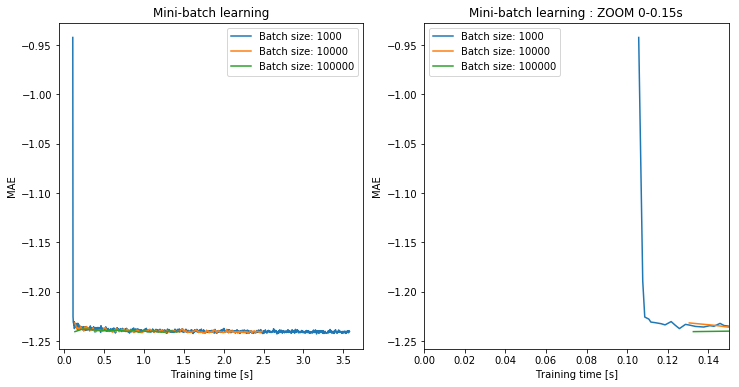

In [92]:
plt.subplot(1,2,1)

for i in range(len(plot_x)):
    plt.plot(plot_x[i], plot_y[i], label = plot_labels[i])
plt.title("Mini-batch learning")
plt.xlabel("Training time [s]")
plt.ylabel('MAE')
plt.legend(loc=0)

plt.subplot(1,2,2)

for i in range(len(plot_x)):
    plt.plot(plot_x[i], plot_y[i], label = plot_labels[i])
plt.title("Mini-batch learning : ZOOM 0-0.15s")
plt.xlabel("Training time [s]")
plt.ylabel('MAE')
plt.xlim(0,0.15)
plt.legend(loc=0)

plt.show()

#그래프가 이상한데

## 실제 예제

여기서는 특성 해싱, 배치 학습, 그리고 SGD를 결합합니다.
지금까지 살펴본 바로는 다음과 같은 이유로 이 방법이 빅데이터를 처리하는 가장 좋은 방법이 될 것입니다.

1. 특성의 수가 일정하다.(특성 해싱)
2. 배치당 관찰치의 수가 일정하다.(배치 학습)
3. 스트리밍 데이터셋을 허용한다.
4. 알고리즘이 확률적이다.(SGD)

이런 모든 사항은 다음과 같은 몇 가지 결과를 보장합니다.

1. 시간에 따라 정제된 모델은 매우 빠르게 만들 수 있다(첫 번째 미니 배치 이후)
2. RAM 사용이 일정하다(모든 미니 배치가 정확히 동일한 크기를 갖기 때문에)
3. 이상적으로는 원하는 만큼 많은 관찰을 다룰 수 있다.

실제 예제로 텍스트 입력을 갖는 Twenty Newsgroups 데이터셋을 사용해봅시다. 이 데이터셋에는 서로 다른 20개의 뉴스 그룹에서 추출한 서로 다른 주제의 20,000개 메세지(텍스트 콘텐츠)가 들어 있습니다. (프로젝트의 웹페이지는 http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups)

목표는 각 문서를 가능한 라벨 중 하나로 분류하는 것입니다(분류 작업임.) 먼저 그것을 로드한 다음 훈련 집합과 테스트 집합으로 분할할 것입니다. 더욱 현실적으로 만들기 위해 데이터셋에서 헤더, 푸터 및 인용된 전자메일을 제거합니다.

In [35]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import HashingVectorizer

to_remove = {'headers', 'footers', 'quotes'}

data_train = fetch_20newsgroups(subset='train', random_state = 101, remove=to_remove)

data_test = fetch_20newsgroups(subset='test', random_state = 101, remove=to_remove)

labels = data_train.target_names
targets = np.unique(data_train.target)


INFO:sklearn.datasets.twenty_newsgroups:Downloading 20news dataset. This may take a few minutes.
INFO:sklearn.datasets.twenty_newsgroups:Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


이제 데이터셋의 미니 배치를 생성하는 함수를 만들어 봅시다.

In [94]:
def get_minibatch_docs(docs, targets, batch_size):
    n_docs = len(docs)
    for i in range(int(n_docs/batch_size)):
        yield(docs[i*batch_size: (i+1)*batch_size],targets[i*batch_size:(i+1)*batch_size])
    if n_docs % batch_size > 0:
        res_rows = n_docs % batch_size
        yield(docs[-res_rows:], targets[-res_rows:])

여기서 핵심 작업은 단순히 문서를 분류하는 것입니다다. 먼저 HashingVectorizer 클래스를 통해 특성 해싱을 적용하며, 이 클래스의 아웃풋은 SGDClassifier(partial_fit 메소드가 있는 다른 클래스)에 공급합니다. Hashing Vectorizer의 아웃풋이 매우 희소하기 때문에 희소 표현을 사용해 미니 배치 크기를 메모리에서 훨씬 더 작게 만드는 추가적인 이점을 보장합니다.

최상의 해시 크기를 파악하기 위해 1000, 5000, 10000, 50000,그리고 100000인 크기로 전체 검색을 수행한 다음 각 학습자에 대해 정확도를 측정해봅시다.

In [95]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import sys

minibatch_size = 1000
values_to_plot = {}

for hash_table_size in {1000,5000,10000,50000,100000}:
    values_to_plot[hash_table_size] = {'time' : [], 'score' : []}
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False, n_features = hash_table_size, ngram_range=(1,1))
    #non_negative = TRUE -> alternate_sign = False로 수정함 
    #non_negative 옵션이 sklearn 버전이 0.19에서는 작동(경고메세지), 0.21에서는 사라짐.
    
    X_test = vectorizer.transform(data_test.data)
    y_test = data_test.target
    
    clf = SGDClassifier(max_iter = 1000, tol = 1e-3, loss='log')#warning 뜸. 수정
    timings = []
    
    for minibatch in get_minibatch_docs(data_train.data, data_train.target, minibatch_size):
        y_train = minibatch[1]
        
        tick = time.time()
        X_train = vectorizer.transform(minibatch[0])
        clf.partial_fit(X_train, y_train, targets)
        
        timings.append(time.time() - tick)
        
        pred = clf.predict(X_test)
    
        values_to_plot[hash_table_size]['score'].append(accuracy_score(y_test,pred))
    values_to_plot[hash_table_size]['time'] = np.cumsum(timings)

마지막으로 각 해시 크기에 대해 시간과 정확도를 나타내는 그래프에 결과를 플롯해봅시다.
그래프의 X기호는 클래시파이어가 모델을 출력할 때의 인스턴스(빛 관련 정확도)입니다.

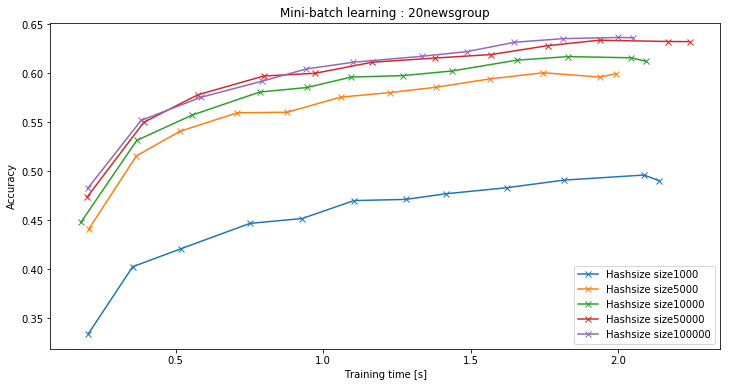

In [96]:
for k,v in sorted(values_to_plot.items()):
    plt.plot(v['time'], v['score'], 'x-', label = 'Hashsize size'+str(k))

plt.title('Mini-batch learning : 20newsgroup')
plt.xlabel('Training time [s]')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.show()

얻은 결과에서 10000개 이상의 큰 해시 테이블을 사용하면 최상의 성능을 얻을 수 있다는 것을 알 수 있습니다. 이 예제에서는 미니 배치의 크기를 1000관찰치로 고정했습니다. 이것은 모든 미니 배치가 희소방식으로 표현된 10M의 요소의 행렬이라는 것을 의미합니다. 또한 모든 미니 배치에 대해 사용된 메모리는 최대 80 MB RAM이라는 것을 의미합니다.

## 테스트셋 없는 스트리밍 시나리오

실제로 테스트 데이터셋을 사용할 수 없는 경우가 많이 있습니다. 그렇다면 우리가 할 수 있는 것은 무엇일까요? 가장 좋은 방법은 다음과 같습니다.

1. 특정한 미니 배치 크기에 도달할 때까지 데이터를 가져온다. 예를 들어 관찰치가 10이라고 가정하자.
2. 관찰치를 섞어서 훈련 집합에 8개를 저장하고, 테스트 집합에 2개를 저장한다(80/20 검증을 위해)
3. 훈련 집합에서 클래시파이어를 훈련시키고, 테스트 집합에서 테스트한다.
4. 단계 1로 돌아간다. 각 미니 배치에서 훈련 집합은 10 관찰치만큼 증가하고 테스트는 2로 설정된다.

지금까지 데이터가 일관되고 데이터셋이 너무크지 않은 경우에 사용되는 전형적인 방법을 설명했습니다. 스트리밍을 통해 특성이 변경되고 특성 통계의 급격한 변화에 적응해야하는 학습자를 구성해야 한다면 테스트셋을 사용하지 않고 다음과 같은 알고리즘을 따르는 것이 좋습니다. 또한 이것은 빅데이터를 활용해 학습하는 데 선호되는 방법입니다.

1. 미니 배치 크기에 도달할 때까지 데이터를 가져온다. 예를 들어 관찰치를 10으로 가정하자. 학습자에게 모든 관찰을 섞어서 훈련시키지 않는다.
2. 다른 미니 배치를 가져올 때까지 기다린다. 이러한 관찰에 대해 클래시파이어를 테스트한다.
3. 이전 단계에서 받은 미니 배치로 클래시파이어를 업데이트한다.
4. 단계 2로 돌아간다.

이 알고리즘의 좋은 점은 모델 및 현재의 미니 배치에 대한 어떤 것도 메모리에 저장할 필요가 없다는 것입니다. 이들은 먼저 학습자를 테스트한 다음 업데이트하는 데 사용됩니다.